### Raniery Mendes ###
#### Exploring Image Segmentation with Deep Learning 

For this project, I rely on the Oxford-IIIT Pet Dataset. It is a 37 category pet dataset with roughly 200 images for each class created by the Visual Geometry Group at Oxford.


In [18]:
#imports 
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np

In [10]:
#if you are trying to reproduce this code, make sure to run "mkdir -p annotations/trimaps/"

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

Visualizing a few samples

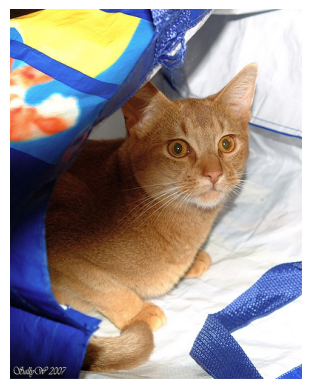

In [5]:

plt.axis("off")
plt.imshow(load_img(input_img_paths[2]))

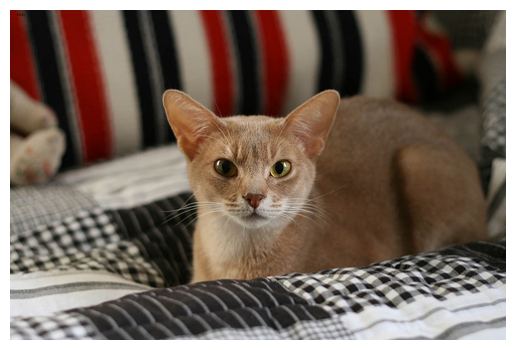

In [6]:
plt.axis("off")
plt.imshow(load_img(input_img_paths[27]))

In [7]:
#function to illustrate what the masking map looks like 
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

In [11]:
len(target_paths)

7390

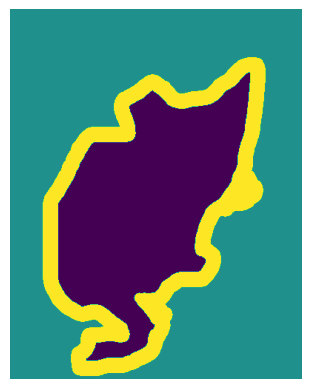

In [13]:
#display map that we'll use as the ground truth
img = img_to_array(load_img(target_paths[2], color_mode="grayscale"))
display_target(img)

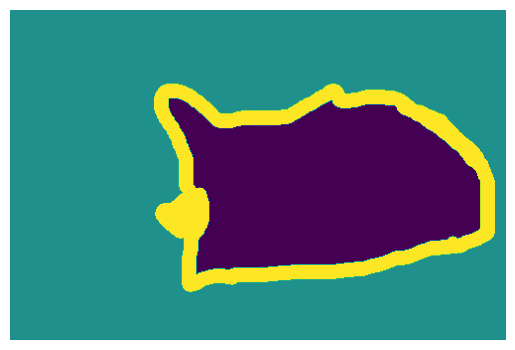

In [14]:
img = img_to_array(load_img(target_paths[27], color_mode="grayscale"))
display_target(img)

In [16]:

#set up input shape and # of samples
img_size = (200, 200)
num_imgs = len(input_img_paths)

#move data around to avoid memorization
random.Random(10).shuffle(input_img_paths) #use same seed for shuffling to make the two match
random.Random(10).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

#set up data tensor and mask "labels"/GT
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
#collect data & labels and store in np tensor
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [21]:
def get_model(img_size, num_classes):
    
    model_instance = keras.Sequential()
    model_instance.add(keras.Input(shape=img_size + (3,)))
    model_instance.add(layers.Rescaling(1./255))
    model_instance.add(layers.Conv2D(64, 3, strides=2, activation="relu", padding="same"))
    model_instance.add(layers.Conv2D(64, 3, activation="relu", padding="same"))
    model_instance.add(layers.Conv2D(128, 3, strides=2, activation="relu", padding="same"))
    model_instance.add(layers.Conv2D(128, 3, activation="relu", padding="same"))
    model_instance.add(layers.Conv2D(256, 3, strides=2, padding="same", activation="relu"))
    model_instance.add(layers.Conv2D(256, 3, activation="relu", padding="same"))

    # upsample latent representation back to size of the input. 
    # We do that by doing the same operations as above,
    #however, in reverse order
    model_instance.add(layers.Conv2DTranspose(256, 3, activation="relu", padding="same"))
    model_instance.add(layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu"))
    model_instance.add(layers.Conv2DTranspose(128, 3, activation="relu", padding="same"))
    model_instance.add(layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same"))
    model_instance.add(layers.Conv2DTranspose(64, 3, activation="relu", padding="same"))
    model_instance.add(layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"))
    model_instance.add(layers.Conv2DTranspose(num_classes, 3, activation="softmax", padding="same"))

    return model_instance

#print info about model. #of trainable parameters per layer
#notice that since we are not learning anything with the rescaling layer, it has 0 param 
model = get_model(img_size=img_size, num_classes=3)
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 200, 200, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#set up loss and optimizer
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

#make sure we only save
callbacks = [
    keras.callbacks.ModelCheckpoint("image_segmentation.keras",
                                    save_best_only=True)
]
#fit the DL model, batch size of 64
history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/step - loss: 0.9718 - val_loss: 0.8913
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 783s 8s/step - loss: 0.8936 - val_loss: 0.8894
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 880s 9s/step - loss: 0.8445 - val_loss: 0.9595
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 832s 8s/step - loss: 0.8303 - val_loss: 0.8369
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 932s 9s/step - loss: 0.7935 - val_loss: 0.7748
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 807s 8s/step - loss: 0.7749 - val_loss: 0.7488
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 803s 8s/step - loss: 0.7518 - val_loss: 0.7477
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 890s 9s/step - loss: 0.7475 - val_loss: 0.7105
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3929s 40s/step - loss: 0.7289 - val_loss: 0.6824
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1233s 12s/step - loss: 0.7145 - val_loss: 0.6703
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1930s 19s/step - loss: 0.6931 - val_loss: 0.6645
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━